In [ ]:
pip install numpy matplotlib tensorflow tensorflow-datasets

In [ ]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_datasets as tfds

In [ ]:
   (ds_train, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    batch_size=32,
    with_info=True,
)

ds_train = ds_train.take(1)

for image, label in ds_train:  # example is (image, label)
  print(image.shape, label)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.9ROF9Z_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
(32, 256, 256, 3) tf.Tensor(
[20 33  1  0  3 24 20 24 35 37 33 24 12 37 36 24 24 35 15 31 20  3  2 19
 34 28 31 25 30  6 34 36], shape=(32,), dtype=int64)


Image shape: (32, 256, 256, 3)
Labels: [16 27  0 24 37  9 24  4 30 31  1 31 28 37 11 28 33 29 25 16 32 15 24 35
 37  6 12 15 18 30 15 32]


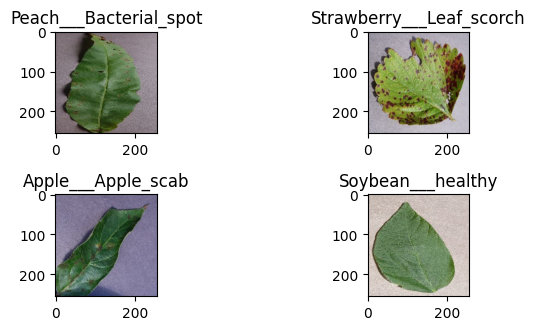

In [ ]:
for images, labels in ds_train.take(1):
    print("Image shape:", images.shape)
    print("Labels:", labels.numpy())
    for i in range(4) : # first 4 images
      plt.subplot(3, 2, i+1)
      plt.subplots_adjust(wspace=2, hspace=2)
      plt.imshow(images[i].numpy())
      plt.title(ds_info.features['label'].names[labels[i]])

plt.tight_layout()
plt.show()

In [ ]:
def resize(image, label):
    image = tf.image.resize(image, (256, 256))
    return image, label

In [ ]:
ds_train = ds_train.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test  = ds_test.map(resize,  num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
normalize = lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
for images, labels in ds_train:
  for i in images: print(i.numpy())

[[[0.5294118  0.49019608 0.5254902 ]
  [0.4627451  0.42352942 0.45882353]
  [0.5568628  0.5176471  0.5529412 ]
  ...
  [0.69803923 0.6627451  0.68235296]
  [0.627451   0.5921569  0.6117647 ]
  [0.6862745  0.6509804  0.67058825]]

 [[0.5137255  0.4745098  0.50980395]
  [0.5568628  0.5176471  0.5529412 ]
  [0.5882353  0.54901963 0.58431375]
  ...
  [0.7058824  0.67058825 0.6901961 ]
  [0.6392157  0.6039216  0.62352943]
  [0.7411765  0.7058824  0.7254902 ]]

 [[0.56078434 0.52156866 0.5568628 ]
  [0.53333336 0.49411765 0.5294118 ]
  [0.5686275  0.5294118  0.5647059 ]
  ...
  [0.7137255  0.6784314  0.69803923]
  [0.7058824  0.67058825 0.6901961 ]
  [0.57254905 0.5372549  0.5568628 ]]

 ...

 [[0.6156863  0.5921569  0.6313726 ]
  [0.6        0.5764706  0.6156863 ]
  [0.5647059  0.5411765  0.5803922 ]
  ...
  [0.7764706  0.7490196  0.7764706 ]
  [0.77254903 0.74509805 0.77254903]
  [0.87058824 0.84313726 0.87058824]]

 [[0.6117647  0.5882353  0.627451  ]
  [0.6627451  0.6392157  0.6784314 ]


In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Freeze the base model weights initially for feature extraction
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
print(f"Features: { ds_info.features['label'].names}")

Features: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 

In [ ]:
num_classes = 38

# Define inputs
inputs = tf.keras.Input(shape=(256, 256, 3))

# Pass inputs through the base model
x = base_model(inputs, training=False)

# Add new classification layers
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

# Create the full model
model = tf.keras.Model(inputs, outputs, name="EfficientNet_PlantVillage")

In [ ]:
# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 256x256 with 3 bytes color
#     # The first convolution
#     tf.keras.Input(shape=(256, 256, 3)),
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # The second convolution
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The third convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fifth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     # Only 1 output neuron. It will give probability for each class since softmax is the activation function
#     tf.keras.layers.Dense(38, dtype='float32', activation='softmax')
# ])

In [ ]:
model.summary()

Model: "EfficientNet_PlantVillage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,103,369 (15.65 MB)

 Trainable params: 4,058,786 (15.48 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Get the first batch of images and labels
for images, labels in ds_train.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 38)


In [ ]:
history = model.fit(
    ds_train,
    epochs=15,
    batch_size=32,
)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 72s 72s/step - accuracy: 0.0000e+00 - loss: 4.5419
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4375 - loss: 2.1799
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4375 - loss: 2.0742
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.2188 - loss: 3.3996
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.6562 - loss: 1.3179
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.8438 - loss: 0.6393
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 1.0000 - loss: 0.0990
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 1.0000 - loss: 0.1287
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 1.0000 - loss: 0.0879
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 1.0000 - loss: 0.1184
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 1.0000 - loss: 0.0125
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 1.0000 - loss: 0.03

In [ ]:
model.evaluate(ds_test, verbose=1)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1013s 3s/step - accuracy: 0.0342 - loss: 3.5951


[3.593904733657837, 0.031212596222758293]

In [ ]:
model.save('plantVillage_EfficitentNet_Model.keras')

In [ ]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.0 MB/s eta 0:00:00


In [ ]:
from ipywidgets import widgets

In [ ]:
from io import BytesIO

# Create the widget and display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file_like, out):
    """Create the prediction and print the output."""
    # Ensure RGB and fixed size
    img = tf.keras.utils.load_img(file_like, target_size=(256, 256), color_mode="rgb")
    img = tf.keras.utils.img_to_array(img)              # float32 array (H, W, 3)
    img = tf.cast(img, tf.float32) / 255.0              # <-- fixed: specify dtype
    img = np.expand_dims(img, axis=0)                   # (1, 256, 256, 3)

    pred = model.predict(img, verbose=0)

    # Print raw scores; adjust as you like
    # For multiclass: show class index
    if pred.ndim == 2 and pred.shape[1] > 1:
        cls = int(np.argmax(pred[0]))
        print(f"{filename}: class={cls}, scores={pred[0]}")
    else:
        # Binary case
        print(f"{filename}: score={float(pred[0][0])}")

def _iter_uploaded(new_value):
    """Yield file dicts from FileUpload.value change, covering both formats."""
    if isinstance(new_value, tuple):
        for d in new_value:
            if isinstance(d, dict) and "content" in d:
                yield d
    elif isinstance(new_value, dict):
        if "content" in new_value and "name" in new_value:
            yield new_value
        else:
            for d in new_value.values():
                if isinstance(d, dict) and "content" in d:
                    yield d

def on_upload_change(change):
    """Get files from the widget and run the prediction."""
    with out:
        for file_dict in _iter_uploaded(change["new"]):
            filename = file_dict.get("name", "uploaded_image")
            content = file_dict["content"]              # bytes
            file_like = BytesIO(content)                # file-like
            file_predict(filename, file_like, out)

# Observe changes
uploader.observe(on_upload_change, names="value")


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()